# <font size="5" color="teal"><div style="text-align: center"> BCG Scientific Programming Python Project <br><br> Project N° 7 <br><i>"Classification of normal vs tumor samples"</i></div></font>

<font size="3"><div style="text-align: right"><strong>A.Y. 2020-2021</strong></div></font>

### Giacomo Mutti 
### Student ID: 10529894 


### **Table of contents**

1. [**Introduction**](#section_1)
2. [**Data mining and preprocessing**](#section_2)
3. [**Exploratory Data Analysis**](#section_3)  
    3.1 [***Samples distribution***](#section_3_1)  
    3.2 [***Gene expression distribution***](#section_3_2)  
    3.3 [***Principal Component Analysis (PCA)***](#section_3_3)
4. [**Classification**](#section_4)  
    4.1 [***PCA reduced dataset***](#section_4_1)  
    4.2 [***Univariate feature selection***](#section_4_2)  
    4.3 [***Recursive Feature Elimination (RFE)***](#section_4_3)
5. [**Discussion & Conclusion**](#section_5)


<a id='section_1'></a>
##  <font color="teal"><div style="text-align: center"> 1. Introduction </div>


<div>

</div>

In this notebook we'll analyse data from The Cancer Genome Atlas Breast Invasive Carcinoma (TGCA-BRCA) data collection. This is a data repository of projects focused on studying breast cancer genotypes. The dataset comprise samples of healthy and sick patients. Each sample has a region file, where the information about genes location and expression is retained, and a metadata file with supplementary information about the sample. 

The main objective of this project is to analyze the data and train classification algorithms to predict the health status of the patient based on gene expression values. This analysis will be executed with classic machine learning algorithms and techniques.

<a id='section_2'></a>
## <font color="teal"><div style="text-align: center">2. Data mining and preprocessing</div>
    
<div>

</div>



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

The data were extracted through the ['GenoSurf'](http://geco.deib.polimi.it/genosurf/) interface with these filters:

- project_name: ['tcga-brca']
- assembly: ['grch38']
- data_type: ['gene expression quantification']
- is_healthy:
    - ['false'] for tumoral data
    - [true] for normal data.

This resulted in a dataset of 1221 samples, each with two URLs linking to the region and metadata files.

In [2]:
# files.txt contains all URLs
url_df = pd.read_table("files.txt", header = None, names = ['url'])

# create column type to differentiate bed and metadata
url_df['type'] = np.where(url_df['url'].str.contains('region'), 'bed', 'metadata')

# create id column (from 1 to 1221) (don't know if necessary or smart)
url_df['idx'] = np.repeat(range(1, int(url_df.shape[0]/2)+1), 2, axis=0)

# pivot old df 
url_df2 = url_df.pivot(index = 'idx', columns='type')

In [3]:
url_df2

url  \
type                                                bed   
idx                                                       
1     http://genomic.deib.polimi.it/gmql-rest/datase...   
2     http://genomic.deib.polimi.it/gmql-rest/datase...   
3     http://genomic.deib.polimi.it/gmql-rest/datase...   
4     http://genomic.deib.polimi.it/gmql-rest/datase...   
5     http://genomic.deib.polimi.it/gmql-rest/datase...   
...                                                 ...   
1217  http://genomic.deib.polimi.it/gmql-rest/datase...   
1218  http://genomic.deib.polimi.it/gmql-rest/datase...   
1219  http://genomic.deib.polimi.it/gmql-rest/datase...   
1220  http://genomic.deib.polimi.it/gmql-rest/datase...   
1221  http://genomic.deib.polimi.it/gmql-rest/datase...   

                                                         
type                                           metadata  
idx                                                      
1     http://genomic.deib.polimi.it/gmql-rest/datase...  
2     http://genomic.deib.polimi.it/gmql-rest/datase...  
3     http://genomic.deib.polimi.it/gmql-rest/datase...  
4     http://genomic.deib.polimi.it/gmql-rest/datase...  
5     http://genomic.deib.polimi.it/gmql-rest/datase...  
...                                                 ...  
1217  http://genomic.deib.polimi.it/gmql-rest/datase...  
1218  http://genomic.deib.polimi.it/gmql-rest/datase...  
1219  http://genomic.deib.polimi.it/gmql-rest/datase...  
1220  http://genomic.deib.polimi.it/gmql-rest/datase...  
1221  http://genomic.deib.polimi.it/gmql-rest/datase...  

[1221 rows x 2 columns]

For each bed file the FPKM column was extracted. FPKM (Fragments Per Kilobase of transcript per Million reads mapped) is a normalised estimation of gene expression based on RNA-seq data. FPKM are calculated from the number of reads that mapped to each particular gene sequence taking into account the gene length and the sequencing depth. Therefore, this measure is often used as a proxy of the level of expression of a gene. The expression data were available for 60484 genes and each gene was identified by its ensemble id. 

The information on the health status of the sample was extracted from the metadata file and was added as a column.

The final result is a dataset comprised of 1221 rows (samples) and 60485 columns (genes + health status)

***
<font size="4" color="darkred"><strong>CAVEAT :</strong></font>

This block of code is really slow as it needs to read 1221 bed files, for this reason it creates a csv file with the resulting dataframe. Therfore, it just needs to be executed once, after that it's just a matter of reading the csv file.
***

In [ ]:
names = ['chromosome', 'start', 'end', 'strand', 'ensembl_gene_id', ' entrez_gene_id', 'gene_symbol', 'type', 'htseq_count',
         'fpkm_uq', 'fpkm']

X = pd.DataFrame()

# for each row of the url dataframe (bed_url and metadata_url) 
# create a row with all gene exp values for each sample +idx + health status

for index, row in url_df2.iterrows():
    bed = pd.read_csv(row[0], sep = "\t", header = None, names = names)
    bed = pd.pivot_table(bed, values='fpkm', index = 'ensembl_gene_id').T
    bed['idx'] = index
    status = pd.read_csv(row[1], sep = "\t", header = None)
    status = list(status[status[0]=='gcm_curated__is_healthy'][1])
    bed['healthy'] = status
    X = X.append(bed)
    print(index)

X['healthy'] = np.where(X['healthy'].str.contains('true'), 1, 0)

# write csv because this is a really slow process
X.to_csv(path_or_buf="./tgca_brca_df.csv", index=False, header=True)

In [4]:
df = pd.read_csv("tgca_brca_df.csv")

In [5]:
df

,ENSG00000000003.13,ENSG00000000005.5,ENSG00000000419.11,ENSG00000000457.12,ENSG00000000460.15,ENSG00000000938.11,ENSG00000000971.14,ENSG00000001036.12,ENSG00000001084.9,ENSG00000001167.13,...,ENSGR0000264819.4,ENSGR0000265658.4,ENSGR0000270726.4,ENSGR0000275287.3,ENSGR0000276543.3,ENSGR0000277120.3,ENSGR0000280767.1,ENSGR0000281849.1,idx,healthy
0,15.038070,14.759733,20.942462,2.805225,0.782528,5.423555,61.054026,22.180747,8.665240,7.745427,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
1,21.802661,0.186906,37.578928,8.083003,2.781439,0.926171,2.171244,16.940115,3.313641,15.485401,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0
2,4.235466,1.325593,30.119492,4.355058,1.077068,2.296780,4.645011,19.172618,5.295792,11.970247,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0
3,15.752438,0.070065,30.681041,4.558432,2.579139,0.885994,9.453277,24.492556,10.038721,17.848583,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0
4,3.293008,0.000000,58.790723,10.826620,4.237957,0.723620,10.267555,14.035519,7.514246,20.990645,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1216,8.534925,1.275444,23.962606,2.772298,1.587575,2.040952,10.367577,26.814668,5.443385,12.276079,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1217,0
1217,33.778203,0.092764,57.867768,5.986377,13.927506,1.007901,2.112773,25.690930,4.360894,49.082549,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1218,0
1218,6.366955,0.586589,35.453655,3.774370,2.524568,3.823734,5.432521,65.775424,6.841912,15.181490,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1219,0
1219,5.670638,0.000000,27.774229,7.714313,2.252915,2.023873,5.397548,28.262694,3.426822,22.280552,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1220,0


To use Scikit API two datasets were produced, one with the features values and one with the target class variable

In [6]:
exp_values = df.drop(columns=['healthy', 'idx'])
no_idx = df.drop(columns=['idx'])
y = df['healthy']

<a id='section_3'></a>
## <font color="teal"><div style="text-align: center"> 3. Exploratory Data Analysis </div></font>

<div>

</div>

In this section we'll explore the dataset by analysing its aspectes and variables. This is done to understand which ML tecnhiques could be more suitable to our study and to have a general idea on the data.
<a id='section_3_1'></a>
###  <font color="teal"> 3.1 Samples distibution</font>
First of all we check how many patients per condition are present. This is essential to our classification purposes.

healthy
0    1108
1     113
Name: idx, dtype: int64


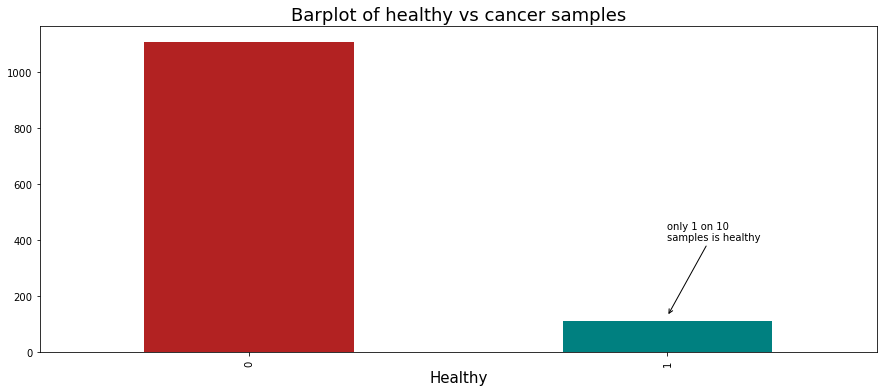

In [7]:
print(df.groupby(['healthy']).count()['idx'])


fig  = plt.figure(figsize = (15,6))
df.groupby('healthy').size().plot(kind='bar', color=['firebrick', 'teal'])
plt.title("Barplot of healthy vs cancer samples", size = 18)
plt.xlabel('Healthy', size=15)
plt.annotate("only 1 on 10\nsamples is healthy", xy = (1,130),
             xytext=(1, 400),
             arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"))

plt.show()

The classes are severly imbalanced as the great majority (90%) of the samples have cancer. This is due to the fact that less controls are analysed than cancer patients due to high cost of the microarrays.
This is very important as it could cause problems to the classification algorithms as they are often based on the assumption of equal distribution of the classes. In our case, the minority class is the least interesting one. This class will be harder to classify as there are less samples and it will be swamped by the majority class. This causes the 'accuracy paradox', which means that a naive model will have a 90% accuracy just by predicting all 0s. For this reason we must be really careful when interpretating the results. A very high accuracy, in this case, may be just due to the fact that all the samples are being classified as having cancer. The main way we dealt with this issue is using different evaluation metrics and techniques.

<a id='section_3_2'></a>
###  <font color="teal"> 3.2 Gene expression distribution
 
To visualize the distribution of the mean values of gene expressions across samples we built a violin plot and a density plot. The same was done for the standard deviation values. Additionaly, the same representation was performed on the two distinct health status classes.

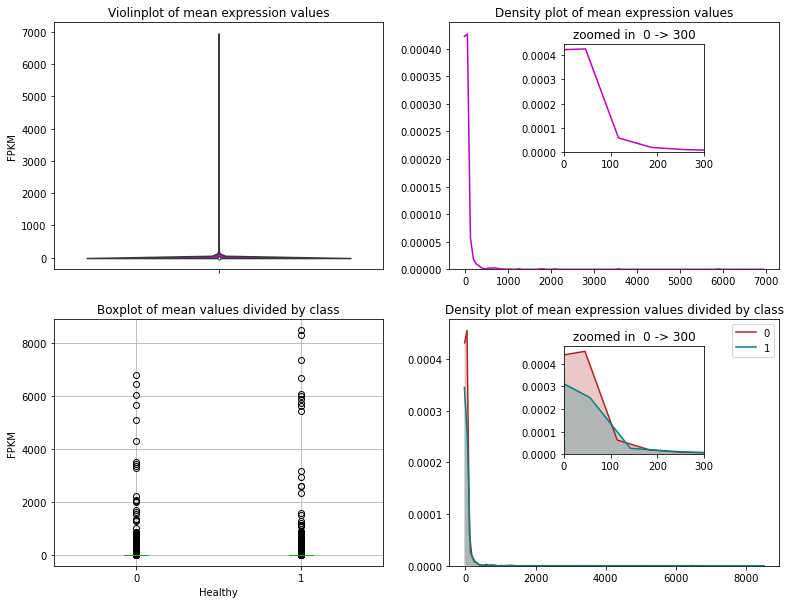

In [8]:
fig, axs = plt.subplots(2, 2, figsize = (13,10))

#first plot violin of mean exp
sns.violinplot(exp_values.mean(axis=0), orient='v', color = 'm', ax = axs[0,0])
axs[0,0].set_title("Violinplot of mean expression values")
axs[0,0].set_ylabel("FPKM")

# second plot boxplot of mean divided by health
no_idx.groupby('healthy').mean().T.boxplot(ax = axs[1,0])
axs[1,0].set_xlabel('Healthy')
axs[1,0].set_ylabel("FPKM")
axs[1,0].set_title("Boxplot of mean values divided by class")

# denisty of mean
axs[0,1].set_title("Density plot of mean expression values")
sns.kdeplot(exp_values.mean(axis = 0), color='m', ax=axs[0,1])
# zoom
ax2 = plt.axes([.67, .7, .15, .15], facecolor='w')
sns.kdeplot(exp_values.mean(axis = 0), color='m', ax=ax2)
ax2.set_title('zoomed in  0 -> 300')
ax2.set_xlim([0,300])

#density divided by class
sns.kdeplot(no_idx.groupby('healthy').mean().T[0], shade=True, color="firebrick", ax = axs[1,1])
sns.kdeplot(no_idx.groupby('healthy').mean().T[1], shade=True, color="teal", ax = axs[1,1])
axs[1,1].set_title("Density plot of mean expression values divided by class")
# zoom
ax3 = plt.axes([.67, .28, .15, .15], facecolor='w')
sns.kdeplot(no_idx.groupby('healthy').mean().T[0], shade=True, color="firebrick", ax = ax3)
sns.kdeplot(no_idx.groupby('healthy').mean().T[1], shade=True, color="teal", ax = ax3)
ax3.set_title('zoomed in  0 -> 300')
ax3.get_legend().remove()
ax3.set_xlim([0,300])

plt.show()

In [9]:
print((exp_values.mean(axis=0)>200).value_counts())
print((exp_values.mean(axis=0)>1000).value_counts())

False    60331
True       152
dtype: int64
False    60462
True        21
dtype: int64


We can see that the mean expression values is mostly distibuted between 0 and 100 fpkm. Very few genes (n=152) have a mean expression greater than 200 FPKM, and fewer (n=21) have really high expression (>1000 fPKM). We can see that cancer samples tend to have more genes with low expression mean.

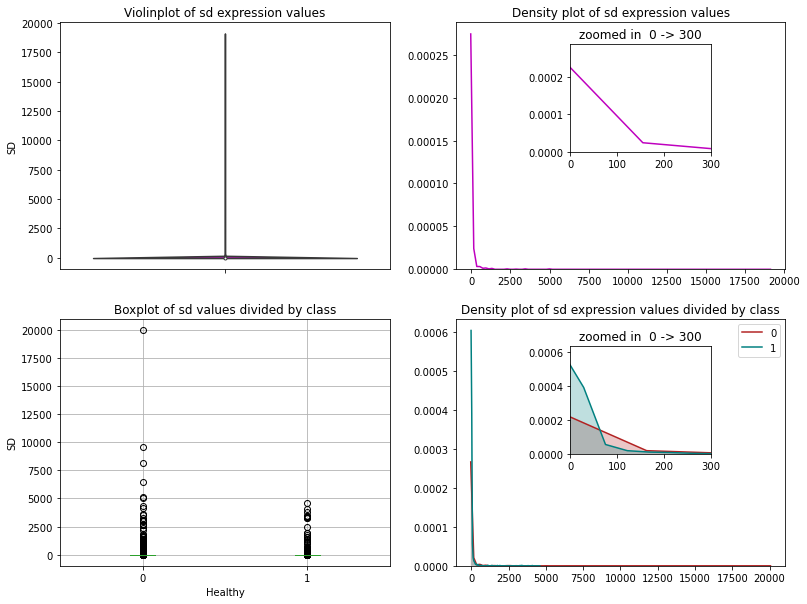

In [10]:
fig, axs = plt.subplots(2, 2, figsize = (13,10))

#first plot violin of std exp
sns.violinplot(exp_values.std(axis=0), orient='v', color = 'm', ax = axs[0,0])
axs[0,0].set_title("Violinplot of sd expression values")
axs[0,0].set_ylabel("SD")

# second plot boxplot of mean divided by health
no_idx.groupby('healthy').std().T.boxplot(ax = axs[1,0])
axs[1,0].set_xlabel('Healthy')
axs[1,0].set_ylabel("SD")
axs[1,0].set_title("Boxplot of sd values divided by class")

# denisty of mean
axs[0,1].set_title("Density plot of sd expression values")
sns.kdeplot(exp_values.std(axis = 0), color='m', ax=axs[0,1])
# zoom
ax2 = plt.axes([.67, .7, .15, .15], facecolor='w')
sns.kdeplot(exp_values.std(axis = 0), color='m', ax=ax2)
ax2.set_title('zoomed in  0 -> 300')
ax2.set_xlim([0,300])

#density divided by class
sns.kdeplot(no_idx.groupby('healthy').std().T[0], shade=True, color="firebrick", ax = axs[1,1])
sns.kdeplot(no_idx.groupby('healthy').std().T[1], shade=True, color="teal", ax = axs[1,1])
axs[1,1].set_title("Density plot of sd expression values divided by class")
# zoom
ax3 = plt.axes([.67, .28, .15, .15], facecolor='w')
sns.kdeplot(no_idx.groupby('healthy').std().T[0], shade=True, color="firebrick", ax = ax3)
sns.kdeplot(no_idx.groupby('healthy').std().T[1], shade=True, color="teal", ax = ax3)
ax3.set_title('zoomed in  0 -> 300')
ax3.get_legend().remove()
ax3.set_xlim([0,300])

plt.show()

As before most of the genes have a SD comprised between 0 and 150. The interesting factor is that genes in cancer samples tend to have higher SD with respect to healthy samples which have more genes with sd near 0. 

<a id='section_3_3'></a>
###  <font color="teal">3.3 Principal Component Analysis (PCA)

To make sense of this immense dataset we can reduce the dimensionality thanks to PCA. This technique allows to visualize the data points in the first 2 or 3 components, preserving as much of the variation as possible. Furthermore, each principal component (PC) explains a proportion of the total variance observed in the dataset. When ***p>n*** the number of PCs is ***n*** if the data are not centered and ***n-1*** if they are. Before performing PCA is always a good idea to normalize the data, in our case we tested both standard scaler (each gene with mean = 0 and sd = 1) and min-max scaling, which trasform the gene expression values to an interval (0,1). We then decided to use min-max scaling in downstream analyses because it gave better results.

In [11]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.feature_selection import SelectKBest, f_classif, RFE

First of all we remove the 2209 columns with only 0 values.

In [12]:
print((exp_values.sum() == 0).value_counts())
exp_nozero = exp_values.loc[:, exp_values.any()]

False    58274
True      2209
dtype: int64


In [13]:
std_scaler = StandardScaler()
mm_scaler = MinMaxScaler()

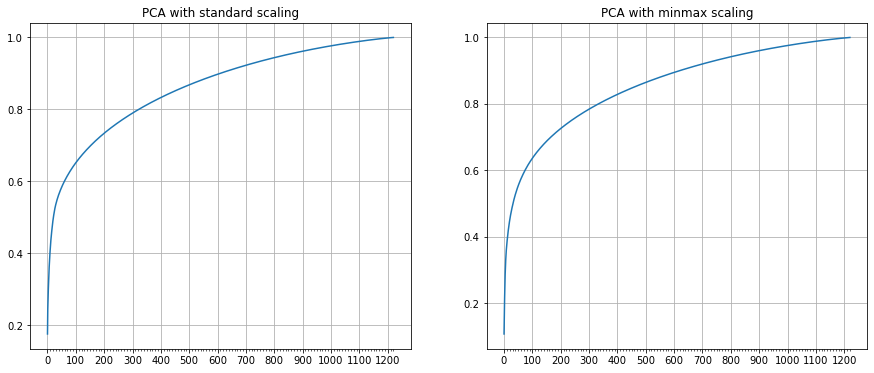

In [14]:
fig, axs = plt.subplots(1, 2, figsize = (15,6))

scaled_X = std_scaler.fit_transform(exp_nozero)
pca = PCA().fit(scaled_X)

major_ticks = np.arange(0, exp_nozero.shape[0], 100)
minor_ticks = np.arange(0, exp_nozero.shape[0], 10)


axs[0].plot(np.cumsum(pca.explained_variance_ratio_))
axs[0].set_title("PCA with standard scaling")

axs[0].set_xticks(major_ticks)
axs[0].set_xticks(minor_ticks, minor=True)
axs[0].grid()


scaled_X_mm = mm_scaler.fit_transform(exp_nozero)
pca = PCA().fit(scaled_X_mm)

axs[1].plot(np.cumsum(pca.explained_variance_ratio_))
axs[1].set_title("PCA with minmax scaling")

axs[1].set_xticks(major_ticks)
axs[1].set_xticks(minor_ticks, minor=True)

axs[1].grid()
plt.show()

We can observe that both scaling perform similarly and that half of the total variation can be explained by more or less 60 components. This will be useful afterwards when we'll use the PCA transformed dataset to train classfication models.
We can also use the first 2 and 3 components of the result to visualize the data points in a reduced space. In 2 dimensions the data are projected over the two dimensions with greater variation in the data. In this case the 1st PC explains 11% and the 2 PC explains 6% of the total variation. Note that from now on we'll perform PCA and other modling over min max scaled data.

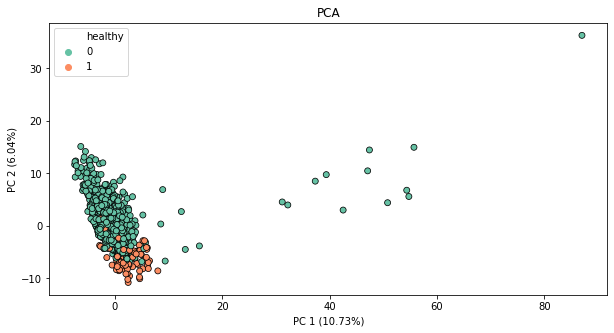

In [15]:
pca = PCA(n_components=2)  
projected2 = pca.fit_transform(scaled_X_mm)

fig = plt.figure(figsize=(10,5))
sns.scatterplot(projected2[:, 0], projected2[:, 1], hue=y, edgecolor='k',
                palette=sns.color_palette("Set2", n_colors=np.unique(y).shape[0]))
plt.xlabel('PC 1 (%.2f%%)' % (pca.explained_variance_ratio_[0]*100))
plt.ylabel('PC 2 (%.2f%%)' % (pca.explained_variance_ratio_[1]*100))
plt.title("PCA")
plt.show()

We can see that most points are distibuted in a cloud that diverges along the 2nd axis. Few samples diverge a lot over the 1st and 2nd axis, all these samples are cancer patients. Healthy and cancer samples are more or less clustered in two quite distinct groups divided along the 2nd axis. We can add the 3rd dimension (that explains another 4% of the variation) to have a more clear distinction of the data points. Note that it is possible to show interactive plots if %matplotlib notebook is added in the script. 

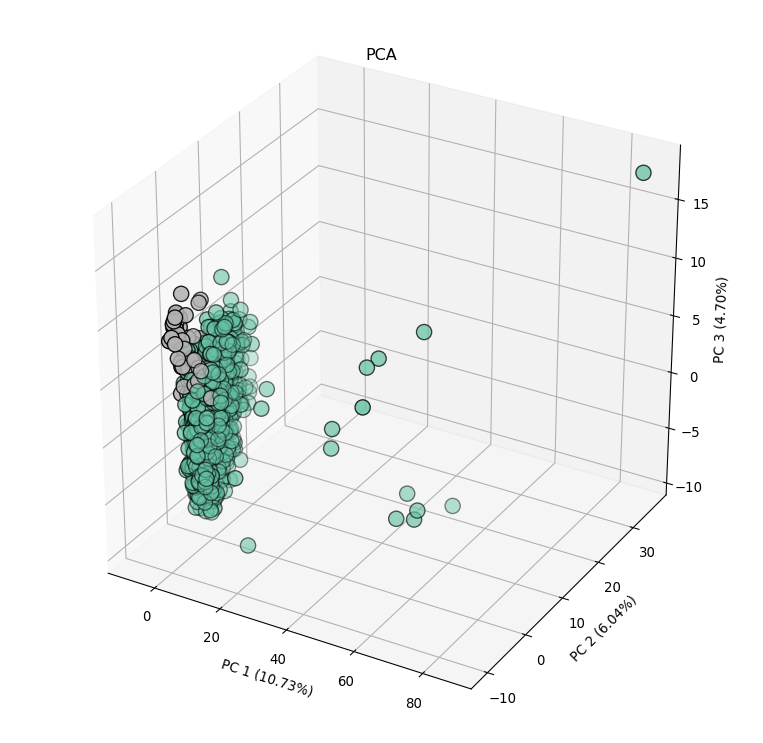

In [16]:
#%matplotlib notebook 
#-> make it interactive
#%matplotlib inline 
#-> make it static

fig = plt.figure(figsize=(10, 10), dpi=96)
ax = fig.add_subplot(111, projection='3d')

pca = PCA(n_components=3)
pca.fit(scaled_X_mm)
X_trans = pca.transform(scaled_X_mm)

sc = ax.scatter(X_trans[:, 0], X_trans[:, 1], X_trans[:, 2], c=y, 
                cmap=plt.cm.get_cmap("Set2"), edgecolor='k', s=130)
    # ax.text(x=0.74048959,y=-1.85937686,z=1.64074746,s= 'ciao')
    #  to check if correct color-legend assignment
    # label the axes
ax.set_xlabel('PC 1 (%.2f%%)' % (pca.explained_variance_ratio_[0]*100))
ax.set_ylabel('PC 2 (%.2f%%)' % (pca.explained_variance_ratio_[1]*100))
ax.set_zlabel('PC 3 (%.2f%%)' % (pca.explained_variance_ratio_[2]*100))
ax.set_title("PCA")
plt.show()

We can see that the distinction between cancer and healthy patitents is somewhat clearer in 3 dimensions. The highly divergent points might bue due to the fact that cancer is a disease that causes an uncontrollable and hetereogenous gene expression. Those points could be patients with late stage cancer or maybe other breast cancer subtypes of which, unluckily we don't have the data.

<a id='section_4'></a>
## <div style="text-align: center"><font color="teal"> 4. Classification </font></div>

<div>

</div>

In [17]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix, f1_score, precision_score, recall_score
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.neighbors import KNeighborsClassifier

To classify the samples we developed a pipeline that follow these steps:

1. Feature selection or dimensionality reduction
2. MinMax scaling
3. Model training
4. Model evaluation

We used 3 different ways to reduce the complexity of our dataset: PCA, univariate feature selection and recursive feature elimination. Given that our dataset had a lot more variables than samples the risk of overfitting the model is really high. So, in this cases, it is always better to do it before training any models.

To better evaluate our models we performed k-fold cross validation with k=5. In this way the dataset is divided in k sections, the models are trained on k-1 sections and are tested on 1 (see Figure). Therefore the models are trained k times. This technique allows to have better estimates of the performance of the model as it's not only trained on one test set. 



The models we decided to train are 6 canonical classification algorithms:

1. Logistic Regression
2. SVC with linear kernel
3. SVC with polynomial kernel
4. K Nearest Neighbours
5. Linear Discriminant Analysis
6. Quadratic Discriminant Analysis

After training the models we assessed their performances on the basis of a confusion matrix for each model and the accuracy of each kfold of each model. Note that the color and the percentages shown in the confusion matrix are based on the proportion of true positives inside the specific class (e.g. 96% means that 96 healthy samples in 100 healthy samples were classfied correctly). This was done to better visualize the corectness of the models predictions, especially for healthy samples that are much less. 

Also a barplot with average f-score, recall and precision over the 5 k-folds for each class was produced. This was done to judge the models with other metrics especially useful when considering a severly imbalanced dataset like ours.

**Precision = TruePositive / (TruePositive + FalsePositive)** -> quantifies the number of correct positive predictions made

**Recall = TruePositives / (TruePositives + FalseNegatives)** -> quantifies the number of correct positive predictions made out of all positive predictions that could have been made

**F-Measure = (2 * Precision * Recall) / (Precision + Recall)** -> combines precision and recall

<a id='section_4_1'></a>
###  <font color="teal">4.1 PCA reduced dataset

First of all we analyze the results of the models performed on PCA reduced dataset with n components = 10. Reducing dimensionality by keeping only the first 10 components should allow our models to not overfit the data. 

================================================== FITTING MODELS ==================================================
Performing logreg ...
Performing linear_SVC ...
Performing poly_SVC ...
Performing knn ...
Performing lda ...
Performing qda ...
================================================== CONFUSION MATRIX ==================================================


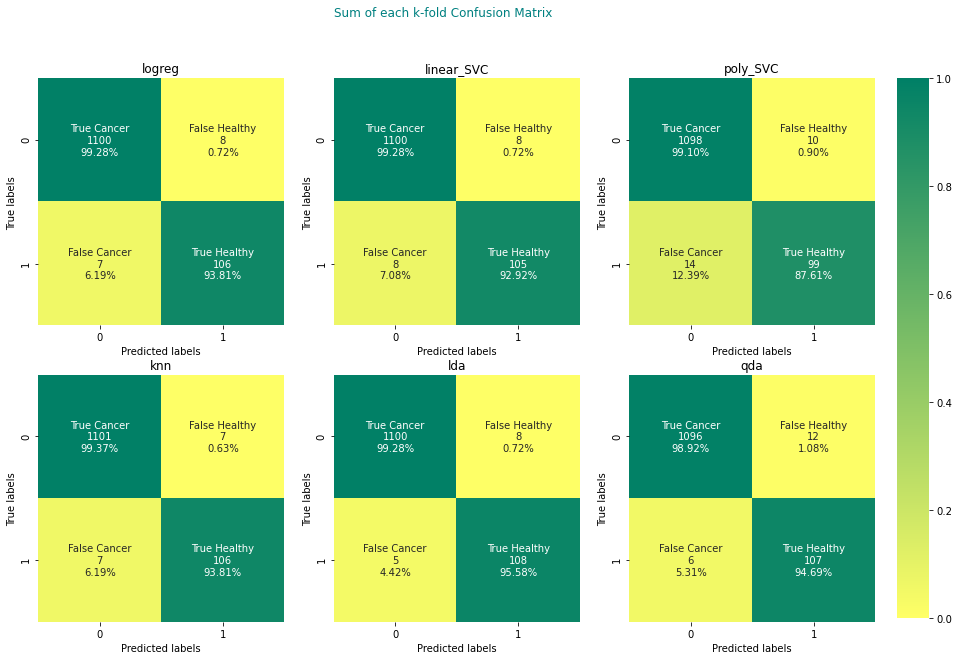

================================================== ACCURACY SCATTERPLOT ==================================================


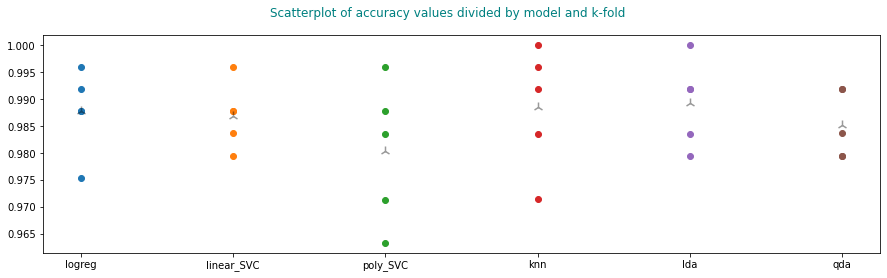

In [22]:
# define models
logreg = LogisticRegression()
linear_SVC = SVC(kernel='linear')
poly_SVC = SVC(kernel='poly')
knn = KNeighborsClassifier(n_neighbors=10)
lda = LinearDiscriminantAnalysis(store_covariance=True)
qda = QuadraticDiscriminantAnalysis(store_covariance=True)

models = [logreg, linear_SVC, poly_SVC, knn, lda, qda]

# and model names
models_names = ['logreg', 'linear_SVC', 'poly_SVC', 'knn', 'lda', 'qda']

# define k fold cross validation
kf = KFold(n_splits=5, shuffle=True)
# keep 10 PC -> this was chosen empirically!
pca = PCA(n_components=10)

# initialize accuracy list to be filled with each k fold accuracy for each model
PCA_acc = []
# initialize  list of dataframe to be filled with all other accuracy metrics
listdf_pca = []

# useful for subplots
pos = 1
fig = plt.figure(figsize=(15,10))
cbar_ax = fig.add_axes([.92, 0.13, .03, .75])

font = {'color':  'teal',
        'weight': 'bold',
        'size': 15}

print("="*50,"FITTING MODELS","="*50)

for i, model in enumerate(models):
    # define pipeline, scaling->PCA->classifier
    clf = Pipeline(steps=[('scaler', mm_scaler),('pca', pca),('m', model)])
    name = models_names[i]
    # to show parameters of each model
    #print(name, "\n", model.get_params())
    print("Performing", name, "...")
    # list of each iteration accuracy
    acc_mod = []
    # will add this to listdf_pca
    df_model = pd.DataFrame() 
    # to plot confusion matrix
    cm = np.zeros((2,2), dtype = 'int64')
    for train_index, test_index in kf.split(exp_nozero):
        # Split train-test
        X_train, X_test = exp_nozero.iloc[train_index], exp_nozero.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        # Train the model
        fitted_model = clf.fit(X_train, y_train)
        pred = fitted_model.predict(X_test)
        
        # Append to accuracy_model the accuracy of the model
        acc_mod.append(accuracy_score(y_test, pred))
        k_df = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        df_model = pd.concat((df_model, k_df))
        cm_k = confusion_matrix(y_test,pred)
        cm = cm + cm_k
    
    PCA_acc.append(acc_mod)
    
    ax_cm = plt.subplot(2,3,pos)
    group_names = ['True Cancer','False Healthy','False Cancer','True Healthy']
    group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in (cm/np.sum(cm,axis=1).reshape(-1,1)).flatten()]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    if pos == 6:
        sns.heatmap(cm/np.sum(cm,axis=1).reshape(-1,1), annot=labels, fmt='', cmap='summer_r', 
                    vmin = 0, vmax = 1, ax = ax_cm, cbar_ax = cbar_ax)
    else:    
        sns.heatmap(cm/np.sum(cm,axis=1).reshape(-1,1), annot=labels, fmt='', cmap='summer_r', 
                    vmin = 0, vmax = 1, ax = ax_cm, cbar = False)

    ax_cm.set_xlabel('Predicted labels')
    ax_cm.set_ylabel('True labels') 
    ax_cm.set_title(name)
    
    pos = pos + 1

    # do mean to each column
    df_model = df_model.groupby(level=0).mean()
    listdf_pca.append(df_model)

fig.suptitle("Sum of each k-fold Confusion Matrix", fontdict = font)
# plt.title("Sum of each k-fold Confusion Matrix") 
print("="*50,"CONFUSION MATRIX","="*50)
plt.show()

df_pca = pd.DataFrame(PCA_acc, index=models_names).T

print("="*50,"ACCURACY SCATTERPLOT","="*50)

fig, ax = plt.subplots(figsize=(15,4))
for i, (name, value) in enumerate(df_pca.iteritems()):
    ax.scatter([i]*len(value), value)
    ax.scatter(i, value.mean(), marker = '2', color = 'black', s=100, alpha = 0.4)
fig.suptitle("Scatterplot of accuracy values divided by model and k-fold", fontdict = font)    
ax.set_xticks(range(len(df_pca.columns)))
ax.set_xticklabels(df_pca.columns)
plt.show()

print("="*120)

We can see that all models have really high accuracy in every k-fold. Polynomial SVC has the highest rate of misclassified healthy patients. Generally speaking however this rate is much higher than misclassfied cancer samples. This was expected as there are much less healthy data points to preprely train the model. For this reason we should not only take in consideration accuracy but other evaluation metrics such as f-score, recall and precision.  

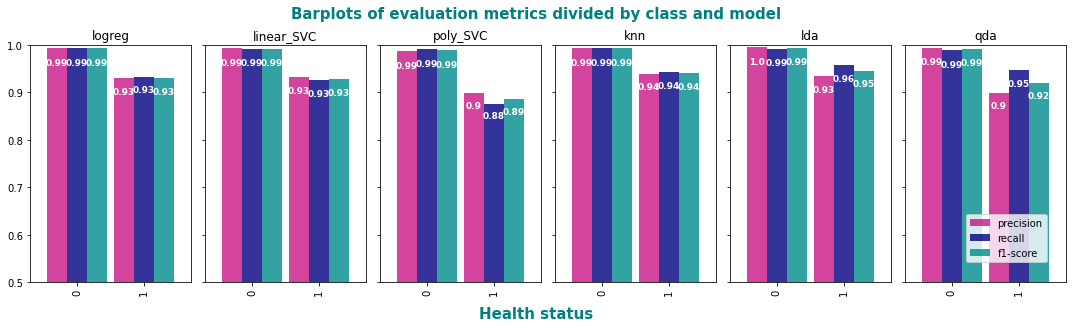

In [41]:
df_all_PCA = pd.DataFrame({'idx':models_names, 'dfs':listdf_pca})

fig, axes = plt.subplots(nrows=1, ncols=6, sharex='row', sharey=True, figsize=(15,4))

for idx in range(df_all_PCA.shape[0]):
    single = df_all_PCA['dfs'].iloc[idx]
    test = single[['0','1']].T.reset_index()
    test.plot(x="index", y=["precision", "recall", "f1-score"], kind="bar", ax=axes[idx], 
              alpha = 0.8, legend=None, width=0.9, color = ['mediumvioletred','navy','darkcyan'])
    axes[idx].set_title(df_all_PCA['idx'].iloc[idx])
    axes[idx].set_xlabel('')
    axes[idx].set_ylim(0.5,1)
    for p in axes[idx].patches:
        axes[idx].annotate(np.round(p.get_height(), decimals = 2), 
                           (p.get_x() + p.get_width()/2., p.get_height() * 0.97),
                           ha='center',va='center', size = 9, color = 'white', weight = 'bold')
    
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.9, 0.2))

fig.text(0.5, -0.04, 'Health status', ha='center', fontdict = font)

plt.tight_layout()

fig.text(0.5,1, "Barplots of evaluation metrics divided by class and model", ha = 'center', fontdict = font)
plt.show()

As expected all metrics for cancer samples are almost perfect whereas for healthy samples are slightly worse. As before only polynomial SVC seems to be the worst classifier. 

<a id='section_4_2'></a>
###  <font color="teal">4.2 Univariate feature selection
    
Now we resort to the first feature selection algorithm. These methods help create more accurate models by selecting important and informative features and removing redundant ones that may decrease the accuracy of the model. Furthermore, they reduce the complexity of the model.
    
The univariate feature selection algorithm is based on statistical tests to select the features which have the strongest relationship with the output class. These methods are really fast and generally they are good at removing non informative, correlated or constant features. However, they are univariate, so they assess each feature independently from the others and this could cause redundant features to be selected as they don't consider interaction between variables. \
First of all, we perform the scikit implementation of the f-classif scorer, this means that for each variable will be performed an ANOVA test. The results of this test is the F-value which basically explicit how the means of the numerical feature differs for each group. We start by using all the features and selecting the features with an f-score greater than the 99th percentile.

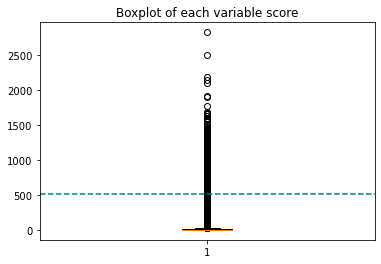

Original number of features: 58274
Reduced number of features: 583


In [54]:
# univariate feature selection

uni_fs = SelectKBest(score_func=f_classif, k='all')
X_uni_fs = uni_fs.fit_transform(scaled_X_mm, y)

max_score = np.percentile(uni_fs.scores_, 99) 
k = sum(uni_fs.scores_ > max_score)

plt.boxplot(uni_fs.scores_)
plt.axhline(y=max_score, color = "teal", linestyle = "dashed")
plt.title('Boxplot of each variable score')
plt.show()

uni_fs = SelectKBest(score_func=f_classif, k=k)
uni_fs.fit(exp_nozero, y)

cols = uni_fs.get_support(indices=True)
X_uni_fs = exp_nozero.iloc[:,cols]

# Show results
print('Original number of features:', exp_nozero.shape[1])
print('Reduced number of features:', X_uni_fs.shape[1])

583 features were selected. We then perform the same classification pipeline as before.

================================================== FITTING MODELS ==================================================
Performing logreg ...
Performing linear_SVC ...
Performing poly_SVC ...
Performing knn ...
Performing lda ...
Performing qda ...


C:\Users\giaco\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\giaco\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\giaco\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\giaco\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\giaco\Anaconda3\lib\site-packages\sklea

================================================== CONFUSION MATRIX ==================================================


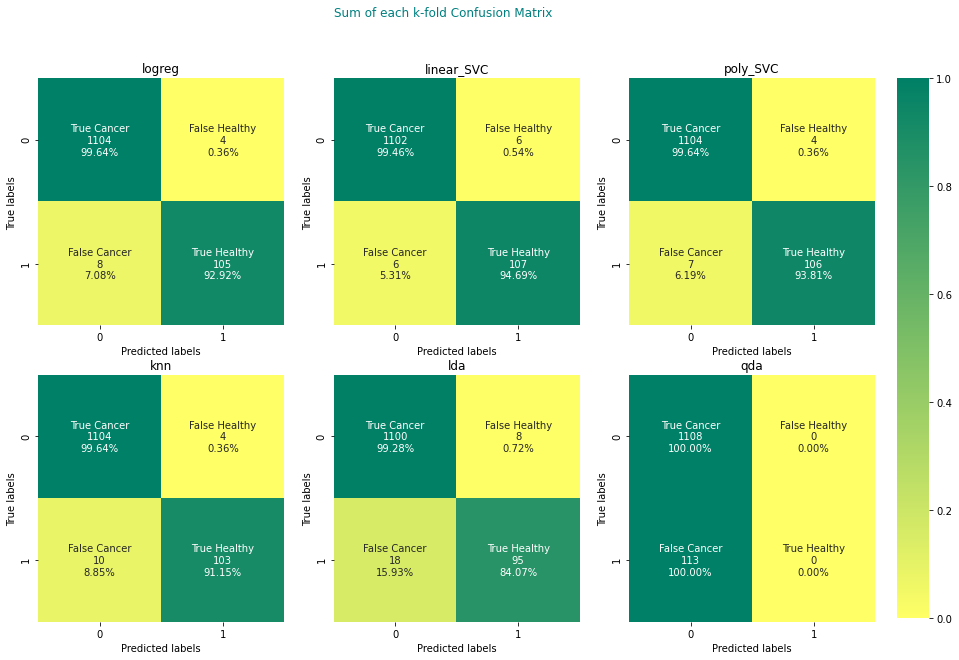

================================================== ACCURACY SCATTERPLOT ==================================================


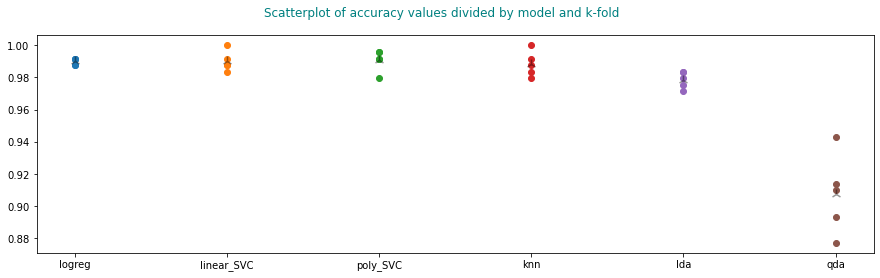

In [56]:
# initialize accuracy list to be filled with each k fold accuracy for each model
univ_acc = []
# initialize  list of dataframe to be filled with all other accuracy metrics
listdf_univ = []

# useful for subplots
pos = 1
fig = plt.figure(figsize=(15,10))
cbar_ax = fig.add_axes([.92, 0.13, .03, .75])

print("="*50,"FITTING MODELS","="*50)

for i, model in enumerate(models):
    # define pipeline, scaling->classifier
    clf = Pipeline(steps=[('scaler', mm_scaler), ('m', model)])
    name = models_names[i]
    
    print("Performing", name, "...")
    
    acc_mod = []
    df_model = pd.DataFrame() 
    cm = np.zeros((2,2), dtype = 'int64')
    
    for train_index, test_index in kf.split(X_uni_fs):
        # Split train-test
        X_train, X_test = X_uni_fs.iloc[train_index], X_uni_fs.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        # Train the model
        fitted_model = clf.fit(X_train, y_train)
        # Append to accuracy_model the accuracy of the model
        pred = fitted_model.predict(X_test)
        
        acc_mod.append(accuracy_score(y_test, pred))
        k_df = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        df_model = pd.concat((df_model, k_df))
        cm_k = confusion_matrix(y_test,pred)
        cm = cm + cm_k
    
    univ_acc.append(acc_mod)
    
    ax_cm = plt.subplot(2,3,pos)
    group_names = ['True Cancer','False Healthy','False Cancer','True Healthy']
    group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in (cm/np.sum(cm,axis=1).reshape(-1,1)).flatten()]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    if pos == 6:
        sns.heatmap(cm/np.sum(cm,axis=1).reshape(-1,1), annot=labels, fmt='', cmap='summer_r', 
                    vmin = 0, vmax = 1, ax = ax_cm, cbar_ax = cbar_ax)
    else:    
        sns.heatmap(cm/np.sum(cm,axis=1).reshape(-1,1), annot=labels, fmt='', cmap='summer_r', 
                    vmin = 0, vmax = 1, ax = ax_cm, cbar = False)

    ax_cm.set_xlabel('Predicted labels')
    ax_cm.set_ylabel('True labels') 
    ax_cm.set_title(name)
    
    pos = pos + 1

    
    df_model = df_model.groupby(level=0).mean()
    listdf_univ.append(df_model)


fig.suptitle("Sum of each k-fold Confusion Matrix", fontdict = font)
# plt.title("Sum of each k-fold Confusion Matrix") 
print("="*50,"CONFUSION MATRIX","="*50)
plt.show()

df_univ = pd.DataFrame(univ_acc, index=models_names).T

print("="*50,"ACCURACY SCATTERPLOT","="*50)

fig, ax = plt.subplots(figsize=(15,4))
for i, (name, value) in enumerate(df_univ.iteritems()):
    ax.scatter([i]*len(value), value)
    ax.scatter(i, value.mean(), marker = '2', color = 'black', s=100, alpha = 0.4)
fig.suptitle("Scatterplot of accuracy values divided by model and k-fold", fontdict = font)    
ax.set_xticks(range(len(df_univ.columns)))
ax.set_xticklabels(df_univ.columns)
plt.show()

print("="*120)    

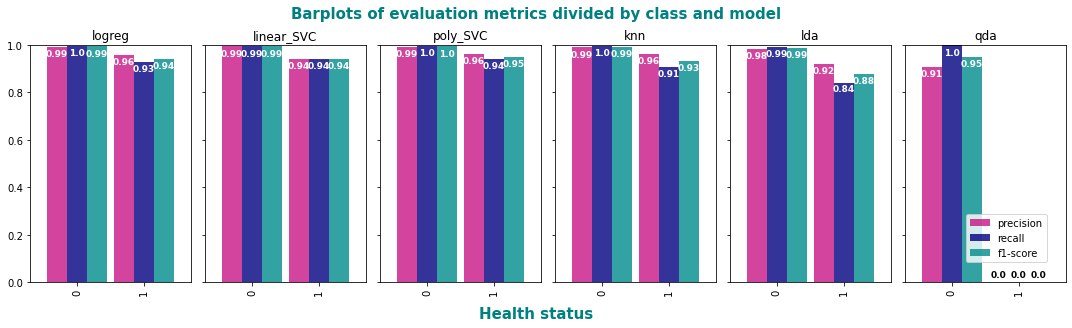

In [107]:
df_all_univ = pd.DataFrame({'idx' : models_names, 'dfs' : listdf_univ})

fig, axes = plt.subplots(nrows=1, ncols=6, sharex='row', sharey=True, figsize=(15,4))

for idx in range(df_all_univ.shape[0]):
    single = df_all_univ['dfs'].iloc[idx]
    test = single[['0','1']].T.reset_index()
    test.plot(x="index", y=["precision", "recall", "f1-score"], kind="bar", ax=axes[idx], 
              alpha = 0.8, legend=None, width=0.9, color = ['mediumvioletred','navy','darkcyan'])
    axes[idx].set_title(df_all_univ['idx'].iloc[idx])
    axes[idx].set_xlabel('')
    axes[idx].set_ylim(0,1)
    for p in axes[idx].patches:
        axes[idx].annotate(np.round(p.get_height(), decimals = 2), 
                           (p.get_x() + p.get_width()/2., 
                            p.get_height() * .97 if p.get_height() != 0 else .03),
                           ha = 'center', va = 'center', size = 9, 
                           color = 'black' if p.get_height() == 0 else 'white',
                           weight = 'bold')
    
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.9, 0.2))
fig.text(0.5, -0.04, 'Health status', ha='center',fontdict = font)
fig.text(0.5,1, "Barplots of evaluation metrics divided by class and model", ha = 'center', fontdict = font)
plt.tight_layout()
plt.show()

Logistic regression, KNN and linear svc performed more or less as before. Polynomial SVC got definetely better whereas both discriminant analyses got worse. LDA only slightly whereas QDA much more. QDA classified all samples as having cancer. These problems are caused by the high correlation of the features (scikit also raises a warning when training QDA). We can explore this factor by plotting a correlation matrix of the selected features.

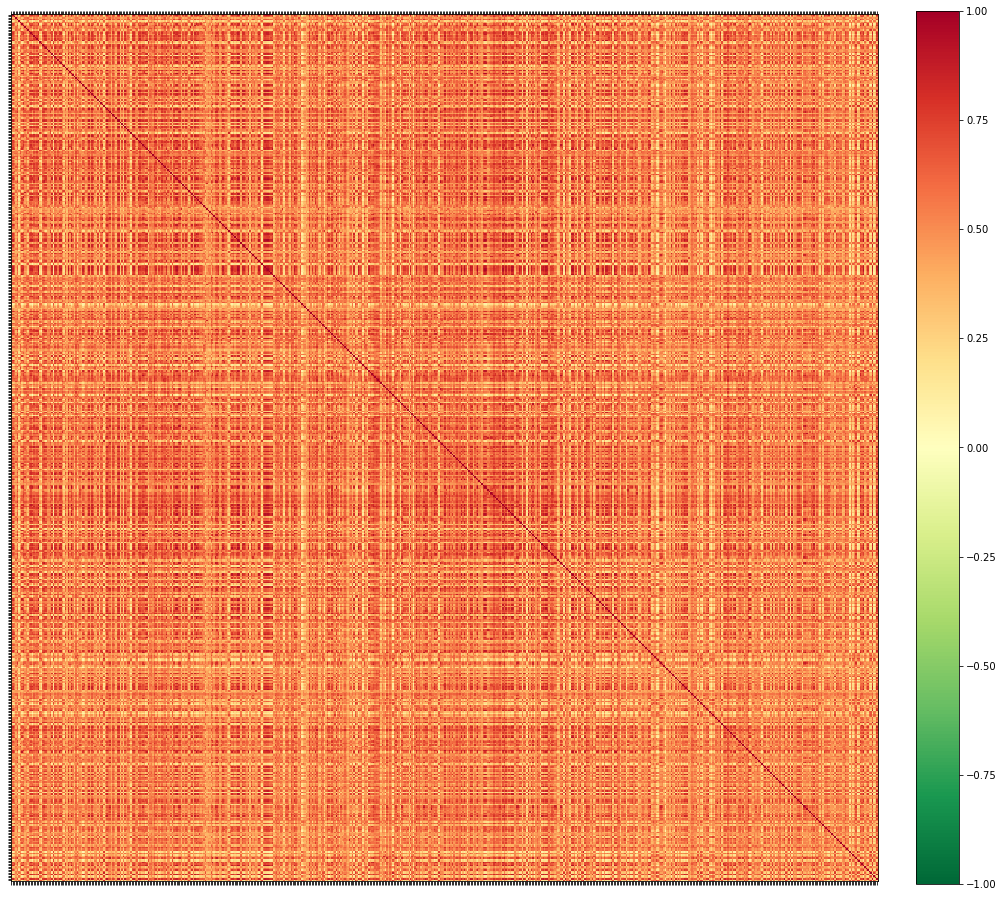

In [80]:
# heatmap for feature correlation
corr_df = X_uni_fs.corr()
#sns.heatmap(corr_df)
fig, ax = plt.subplots(figsize=(17,17)) 

cax = ax.matshow(corr_df,cmap='RdYlGn_r', vmin=-1, vmax=1)
fig.colorbar(cax,fraction=0.046, pad=0.04)
ticks = np.arange(0,len(X_uni_fs.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.show()

As expected the features are extremely correlated. This exposes the main issue with univariate feature selection. Which is that interactions between features are not considered.

<a id='section_4_3'></a>
###  <font color="teal">4.3 Recursive Feature Elimination (RFE)
    

This method works by recursively removing attributes. It can be used only with classifiers that explicit feature importance. In our case we used linear SVC. At the beginning it uses all the data features deriving each feature importance. Remove the least important feature and retrain the model, calculating the performance metrics (in our case we used accuracy). Test if the performance decreases significantly. Finally repeat previous steps until all features are evaluated. 
We used this method because its easier implementation in scikt with respect to forward and backward selection.
    
To compute these we needed to set the step parameter (how many features are removed each iteration) to 1000 otherwise computations would have been unfeasible. We decided to keep 40 features.

In [111]:
model_rfe = SVC(kernel = 'linear')
rfe = RFE(estimator=model_rfe, n_features_to_select = 40, step = 1000)
pipeline = Pipeline(steps=[('s', rfe),('m', model_rfe)])
# evaluate model

pipeline.fit(exp_nozero, y)

print("Optimal number of features : %d" % rfe.n_features_)

# Plot number of features VS. cross-validation scores

mask = rfe.get_support()
features_rfe = exp_nozero.columns[mask]
print(features_rfe)

X_rfe = exp_nozero[features_rfe]

Optimal number of features : 40
Index(['ENSG00000075624.12', 'ENSG00000099194.5', 'ENSG00000100097.10',
       'ENSG00000107796.11', 'ENSG00000110484.6', 'ENSG00000113140.9',
       'ENSG00000116741.7', 'ENSG00000117984.11', 'ENSG00000118523.5',
       'ENSG00000120129.5', 'ENSG00000135046.12', 'ENSG00000137818.10',
       'ENSG00000143556.7', 'ENSG00000145423.4', 'ENSG00000149021.5',
       'ENSG00000152583.11', 'ENSG00000156508.16', 'ENSG00000161055.3',
       'ENSG00000162896.5', 'ENSG00000163191.5', 'ENSG00000166033.10',
       'ENSG00000168542.11', 'ENSG00000170323.7', 'ENSG00000182492.14',
       'ENSG00000184009.8', 'ENSG00000186081.10', 'ENSG00000197956.8',
       'ENSG00000198804.2', 'ENSG00000205542.9', 'ENSG00000210196.2',
       'ENSG00000211679.2', 'ENSG00000211892.3', 'ENSG00000211893.3',
       'ENSG00000211895.4', 'ENSG00000211899.6', 'ENSG00000212907.2',
       'ENSG00000225630.1', 'ENSG00000225972.1', 'ENSG00000227097.5',
       'ENSG00000231500.5'],
      dtype='obje

================================================== FITTING MODELS ==================================================
Performing logreg ...
Performing linear_SVC ...
Performing poly_SVC ...
Performing knn ...
Performing lda ...
Performing qda ...
================================================== CONFUSION MATRIX ==================================================


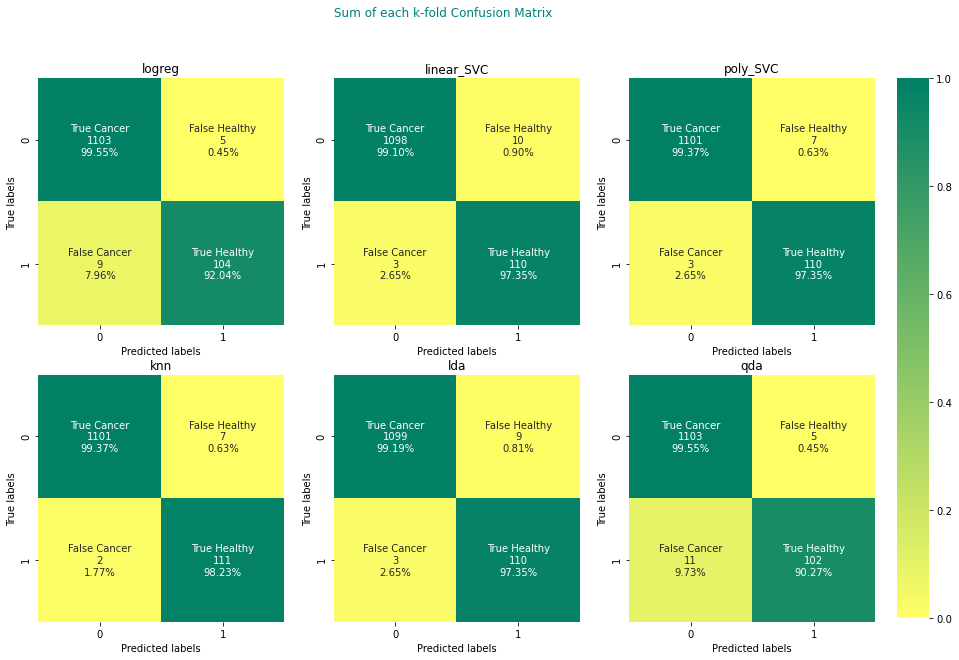

================================================== ACCURACY SCATTERPLOT ==================================================


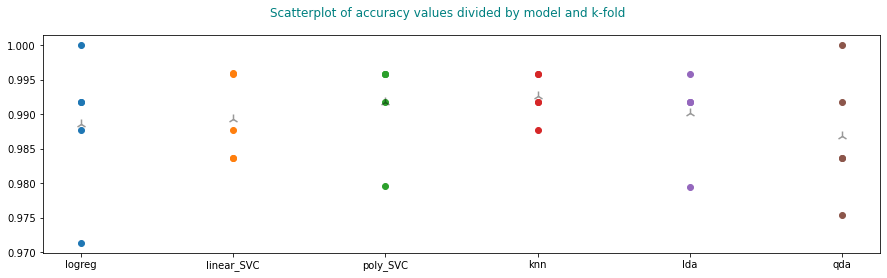

In [112]:
rfe_acc = []
listdf_rfe = []

# useful for subplots
pos = 1
fig = plt.figure(figsize=(15,10))
cbar_ax = fig.add_axes([.92, 0.13, .03, .75])

print("="*50,"FITTING MODELS","="*50)

for i, model in enumerate(models):
    clf = Pipeline(steps=[('scaler', mm_scaler), ('m', model)])
    name = models_names[i]
    print("Performing", name, "...")
    
    acc_mod = []
    df_model = pd.DataFrame() 
    
    cm = np.zeros((2,2), dtype = 'int64')
    
    for train_index, test_index in kf.split(X_rfe):
        # Split train-test
        X_train, X_test = X_rfe.iloc[train_index], X_rfe.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        # Train the model
        fitted_model = clf.fit(X_train, y_train)
        # Append to accuracy_model the accuracy of the model
        pred = fitted_model.predict(X_test)
        acc_mod.append(accuracy_score(y_test, pred))
        k_df = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        df_model = pd.concat((df_model, k_df))
        cm_k = confusion_matrix(y_test,pred)
        cm = cm + cm_k
    
    rfe_acc.append(acc_mod)
    
    ax_cm = plt.subplot(2,3,pos)
    group_names = ['True Cancer','False Healthy','False Cancer','True Healthy']
    group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in (cm/np.sum(cm,axis=1).reshape(-1,1)).flatten()]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    if pos == 6:
        sns.heatmap(cm/np.sum(cm,axis=1).reshape(-1,1), annot=labels, fmt='', cmap='summer_r', 
                    vmin = 0, vmax = 1, ax = ax_cm, cbar_ax = cbar_ax)
    else:    
        sns.heatmap(cm/np.sum(cm,axis=1).reshape(-1,1), annot=labels, fmt='', cmap='summer_r', 
                    vmin = 0, vmax = 1, ax = ax_cm, cbar = False)

    ax_cm.set_xlabel('Predicted labels')
    ax_cm.set_ylabel('True labels') 
    ax_cm.set_title(name)
    
    pos = pos + 1

    df_model = df_model.groupby(level=0).mean()
    listdf_rfe.append(df_model)

fig.suptitle("Sum of each k-fold Confusion Matrix", fontdict = font)
print("="*50,"CONFUSION MATRIX","="*50)
plt.show()

df_rfe = pd.DataFrame(rfe_acc, index=models_names).T

print("="*50,"ACCURACY SCATTERPLOT","="*50)

fig, ax = plt.subplots(figsize=(15,4))
for i, (name, value) in enumerate(df_rfe.iteritems()):
    ax.scatter([i]*len(value), value)
    ax.scatter(i, value.mean(), marker = '2', color = 'black', s=100, alpha = 0.4)
fig.suptitle("Scatterplot of accuracy values divided by model and k-fold", fontdict = font)    
ax.set_xticks(range(len(df_rfe.columns)))
ax.set_xticklabels(df_rfe.columns)
plt.show()

print("="*120)

df_all_rfe = pd.DataFrame({'idx':models_names, 'dfs':listdf_rfe})

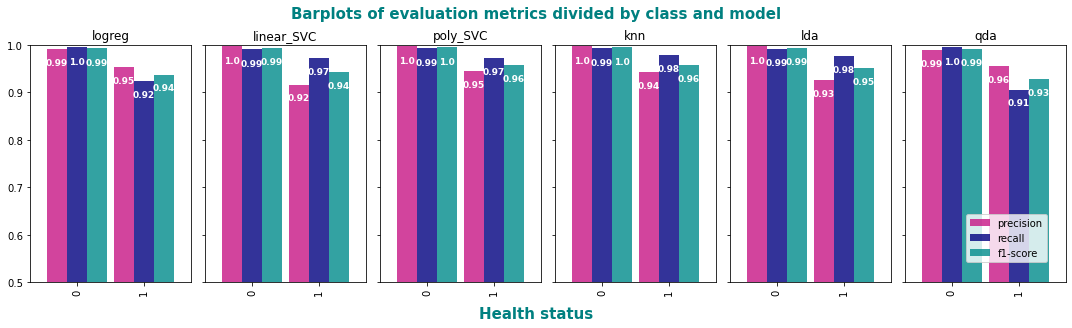

In [113]:
fig, axes = plt.subplots(nrows=1, ncols=6, sharex='row', sharey=True, 
                         figsize=(15,4))

for idx in range(df_all_rfe.shape[0]):
    single = df_all_rfe['dfs'].iloc[idx]
    test = single[['0','1']].T.reset_index()
    test.plot(x="index", y=["precision", "recall", "f1-score"], kind="bar", ax=axes[idx],
              alpha = 0.8, legend=None, width=0.9, color = ['mediumvioletred','navy','darkcyan'])
    axes[idx].set_title(df_all_rfe['idx'].iloc[idx])
    axes[idx].set_xlabel('')
    axes[idx].set_ylim(0.5,1)
    for p in axes[idx].patches:
        axes[idx].annotate(np.round(p.get_height(), decimals = 2), 
                           (p.get_x() + p.get_width()/2., p.get_height() * 0.97), 
                           ha='center',va='center', size = 9, color = 'white', weight = 'bold')
        
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.9, 0.2))

fig.text(0.5, -0.04, 'Health status', ha='center', fontdict = font)
plt.tight_layout()
fig.text(0.5,1, "Barplots of evaluation metrics divided by class and model", ha = 'center', fontdict = font)
plt.show()

Generally speaking the performances are really good with KNN and both SVCs being the best models. Still, all the models have really high accuracy and f-score. This method of feature selection seems to be the best for this dataset.

<a id='section_5'></a>
## <div style="text-align: center"><font color="teal"> 5. Discussion & Conclusion</font></div>

<div>

</div>

Overall the classification of the TGCA-BRCA dataset had really good results. No model clearly outperformed the others. QDA showed limitations when the models are trained with correlated features. 

As expected, all models had more problems classifying healthy samples with respect to cancer samples due to the imbalance of the classes, however almost all the models had f-score for the healthy class > 0.9. 

The models trained on PCA reduced dataset had great performances except for polynomial SVC that had a signicant decrease in identifying healthy samples. 

Surely, univariate feature selection is the worst feature selection algorithm tested. Despite that, it's the less computationally intensive one, so, it might be used only when resources are limited. 

RFE seems to be the best feature selection algorithm for this dataset as all the models performed smoothly. But, it requires a lot of time and resources. Regarding this, it would have been great to implement RFE with cross validation or a smaller step size but it was not feasible.

### <div style="text-align: center"><font color="teal"><em> Thanks for the attention! <br><br> Giacomo Mutti </em></font></div>
<div>

</div>